# Модель прогнозирования оттока пользователей JustKids

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Нажмите, чтобы показать/скрыть код"></form>''')

# Оглавление

1. [Изучение данных и предобработка](#1step)  
2. [Обработка категориальных переменных](#2step)
3. [Корреляция числовых признаков](#3step)
4. [Построение модели](#4step)
    4.1. [Без resampling-а целевой переменной](#4.1step)
    4.2. [С downsampling-ом целевой переменной](#4.2step)
    4.3. [С oversampling-ом целевой переменной](#4.3step)
    4.4. [По самым важным признакам](#4.4step)

In [2]:
import pandas as pd
import numpy as np

#библиотеки для визулизации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#библиотеки машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve

pd.set_option('display.max_columns', 30)

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('Students_churn_matrix_2020_10_15.csv')

Для построения модели были использованы данные по студентам с учетом следующих условий:
1. Дата первой активности студента не должна быть позже, чем 8 недель назад от текущей даты. Это позволяет учесть только тех студентов, которые "прожили" 0-3 неделю, для которых мы рассчитывали показатели и после этого прошли еще 4 недели, по которым мы определяем отток  


2. Дата первой активности равна дате первого урока студента при условии, что у этого урока указан id (pl.id is not null), урок не является пробным уроком (pl.type != 'trial'), урок имеет статус 2 или 4 (pl.status = 2 or pl.status = 4)  


3. Дата последней активности определяется исходя из тех же условий, что и дата первой активности  


4. Выборка исключает тех студентов, у которых на балансе -1 урок (lc.counter != -1)  

**В данной модели под "оттоком" понимается отсутствие активности у пользователя (прохождение платных уроков) в течение 4х недель.**

## 1. Изучение данных и предобработка <a name="1step"></a>

Посмотрим на данные:

In [4]:
df.head()

,id,first_activity,last_activity,age,gender,language_level,utm_source,utm_medium,is_trial,is_trial_completed,new,completed,declined,student_skipped,teacher_skipped,canceled,changes,is_lead_successful,amount_paid,payments,promocode,is_churn
0,13577,2020-03-03,2020-06-18,13,1,4,fb,fb,0,0,0,10,0,0,0,0,1,1,0.0,0,none,1
1,13355,2020-02-29,2020-10-06,14,2,5,fb,none,0,0,0,9,0,1,0,0,2,1,1880.0,1,none,0
2,13120,2020-03-07,2020-09-30,15,1,6,fb,fb,0,0,0,10,0,0,0,0,0,1,2520.0,1,none,0
3,13215,2020-03-12,2020-04-29,8,2,3,fb,fb,0,0,0,6,0,0,0,0,0,1,1880.0,1,none,1
4,13212,2020-03-14,2020-05-02,15,2,4,fb,ig,0,0,0,6,0,0,1,0,0,1,1880.0,1,none,1


Проверим типы данных и наличие пропусков:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  6238 non-null   int64  
 1   first_activity      6238 non-null   object 
 2   last_activity       6238 non-null   object 
 3   age                 6238 non-null   int64  
 4   gender              6238 non-null   object 
 5   language_level      6238 non-null   object 
 6   utm_source          6238 non-null   object 
 7   utm_medium          6224 non-null   object 
 8   is_trial            6238 non-null   int64  
 9   is_trial_completed  6238 non-null   int64  
 10  new                 6238 non-null   int64  
 11  completed           6238 non-null   int64  
 12  declined            6238 non-null   int64  
 13  student_skipped     6238 non-null   int64  
 14  teacher_skipped     6238 non-null   int64  
 15  canceled            6238 non-null   int64  
 16  change

Признаки в датасете преимущественно числовые, но есть также и категориальные, которые нам предстоит преобразовать перед тем, как обучать модель.  
Пропуски присутствуют только по признаку utm_medium, 14 пропусков, заменим пропуски на 'none'.

In [6]:
df['utm_medium'] = df['utm_medium'].fillna('none')

Заменим также тип first_activity и last_activity на формат даты и времени:

In [7]:
df['first_activity'] = pd.to_datetime(df['first_activity'], format='%Y-%m-%d')
df['last_activity'] = pd.to_datetime(df['last_activity'], format='%Y-%m-%d')

Проверим на наличие некорректных данных:

In [8]:
df.describe()

,id,age,is_trial,is_trial_completed,new,completed,declined,student_skipped,teacher_skipped,canceled,changes,is_lead_successful,amount_paid,payments,is_churn
count,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000
mean,16292.935236,9.460725,0.457358,0.422892,0.048092,8.841135,0.186117,0.415037,0.016832,0.156781,0.820295,0.593459,1974.025636,0.800417,0.631933
std,8830.965756,3.579686,0.498218,0.494058,0.447603,2.960581,0.479317,0.802480,0.131122,0.457715,1.595425,0.491227,1850.283731,0.615199,0.482318
min,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8799.750000,7.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16262.000000,9.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1880.000000,1.000000,1.000000
75%,23983.500000,11.000000,1.000000,1.000000,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2520.000000,1.000000,1.000000
max,31855.000000,155.000000,1.000000,1.000000,12.000000,41.000000,7.000000,10.000000,2.000000,10.000000,26.000000,1.000000,21520.000000,5.000000,1.000000


Можно заметить, что максиальное значение возраста - 155 лет, минимальное - 0 лет. Очевидно, что это некорретные данные. 

Мы проверили, что среди студентов действительно встречаются дети в возрасте от 3х лет (по таблице amocrm_leads_static), однако нет студентов в возрасте 0,1 год и 155. Посчитаем, сколько в датасете студентов с неправильным значением возраста:

In [9]:
print('Некорректный возраст наблюдается у {} студентов, что составляет {:.2%}'\
              .format(len(df.query('age in (0,1,155)')), len(df.query('age in (0,1,155)'))/len(df)))

Некорректный возраст наблюдается у 40 студентов, что составляет 0.64%


Менее чем у 1% студентов указан некорректный возраст. Удалим этих студентов для того, чтобы не искажать входные данные для модели.

In [10]:
df = df.query('age not in (0,1,155)')

#### Обработка дубликатов.

Проверим, что в данных нет дублирования по id студента:

In [11]:
duplicated_ids = df['id'].value_counts().sort_values(ascending = False).reset_index()
duplicated_ids = duplicated_ids.query('id>1')
duplicated_ids_list = duplicated_ids['index'].unique()

In [12]:
len(duplicated_ids_list)

56

Было обнаружено, что в датасете есть студенты, у которых дублируется информация. 
Было выявлено, что это связано:

1. с тем, что некоторые студенты за первые 4 недели оплачивали уроки более 1 раза и для одного раза использовали промокод, для второго - нет. Было принято решение оставить строку с промокодом.

2. со столбцами 'is_lead_successful' и 'is_trial': в некоторых ситуациях id студента один, а id лидов для этого студента - больше одного. При этом один лид успешно реализован => значение 'is_lead_successful' = 1, а другой - нет, значение 0. Аналогичная ситуация для пробных уроков.

    Какое было принято решение для обработки таких студентов:
    * если у студента есть два разных значения is_lead_successful (0 и 1) => оставляем только 1
    * если у студента есть два разных значения is_trial (0 и 1) => оставляем только 1

**Порядок действий для обработки дубликатов по промокоду:**  
1. Выделим список тех студентов, у которых дублирование связано с промокодами.
2. Очистим датасет от этих студентов.
3. Добавим к датасету этих студентов вновь, но оставим только одну строку для каждого студента, с промокодом

In [13]:
mult_promocode = (df.query('id in @duplicated_ids_list')
                   .groupby('id')
                   .agg({'promocode':'nunique'})
                   .reset_index()
                )
mult_promocode = mult_promocode.query('promocode > 1')
len(mult_promocode)

7

In [14]:
mult_promocode_list = mult_promocode['id'].unique()

In [15]:
print('Количество уникальных id студентов до обработки дубликатов:', len(df['id'].unique()))

Количество уникальных id студентов до обработки дубликатов: 6141


In [16]:
df_mult_promocode_clean = df.query('id in @mult_promocode_list and promocode != "none"')
df_wo_duplicates = df.query('id not in @mult_promocode_list')
(len(df_mult_promocode_clean))

7

In [17]:
df = pd.concat([df_wo_duplicates,df_mult_promocode_clean])

In [18]:
print('Количество уникальных id студентов после избавления от дубликатов:', len(df['id'].unique()))

Количество уникальных id студентов после избавления от дубликатов: 6141


**Порядок действий для обработки дубликатов по лидам:**  
1. Выделим список тех студентов, у которых дублирование связано с наличием нескольких лидов для 1 студента.
2. Очистим датасет от этих студентов.
3. Добавим к датасету этих студентов вновь, но оставим только одну строку для каждого студента.

In [19]:
duplicated_ids_upd = df['id'].value_counts().sort_values(ascending = False).reset_index()
duplicated_ids_upd = duplicated_ids_upd.query('id>1')
duplicated_ids_upd_list = duplicated_ids_upd['index'].unique()

In [20]:
len(duplicated_ids_upd_list)

49

In [21]:
multiple_leads = (df.query('id in @duplicated_ids_upd_list')
                   .groupby('id')
                   .agg({'is_lead_successful':'nunique','is_trial':'nunique'})
                   .sort_values('is_lead_successful', ascending = False)
                   .reset_index()
       )
multiple_leads.head()

,id,is_lead_successful,is_trial
0,671,2,1
1,25144,2,2
2,18884,2,2
3,936,2,1
4,19621,2,2


In [22]:
print('Количество уникальных id студентов до обработки дубликатов:', len(df['id'].unique()))

Количество уникальных id студентов до обработки дубликатов: 6141


In [23]:
df_wo_duplicates = df.query('id not in @duplicated_ids_upd_list')

In [24]:
df_mult_leads_clean = (df.loc[df['id'].isin(duplicated_ids_upd_list)]
                           .groupby(['id', 'first_activity', 'last_activity', 'age', 'gender',
                           'language_level', 'new', 'completed', 'declined', 'student_skipped','teacher_skipped', 
                           'canceled', 'changes','amount_paid', 'payments', 'promocode', 'is_churn'], as_index=False)
                           .agg({'is_lead_successful':'max','is_trial':'max','is_trial_completed':'max','utm_source':'max','utm_medium':'max'})
)
len(df_mult_leads_clean)

49

In [25]:
df = pd.concat([df_wo_duplicates,df_mult_leads_clean])

In [26]:
print('Количество уникальных id студентов после избавления от дубликатов:', len(df['id'].unique()))

Количество уникальных id студентов после избавления от дубликатов: 6141


In [27]:
duplicated_ids = df['id'].value_counts().sort_values(ascending = False).reset_index()
duplicated_ids = duplicated_ids.query('id>1')
print('Количество дубликатов в id студентов после обработки: {}'.format(len(duplicated_ids)))

Количество дубликатов в id студентов после обработки: 0


## 2. Обработка категориальных переменных <a name="2step"></a> 

In [28]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('Всего в датасете {} категориальных переменных\n'.format(len(categorical)))

print('Список категориальных переменных :\n\n', categorical)

Всего в датасете 5 категориальных переменных

Список категориальных переменных :

 ['gender', 'language_level', 'utm_source', 'utm_medium', 'promocode']


#### 1. gender

In [29]:
df['gender'].value_counts()

1       2715
2       2529
none     897
Name: gender, dtype: int64

In [30]:
print('Признак пола отсутствует для {:.2%} пользователей'.format(len(df.query('gender == "none"'))/len(df)))

Признак пола отсутствует для 14.61% пользователей


Заменим пол = 'none' на значение 0 - 'пол не указан'

In [31]:
df['gender'] = df['gender'].replace(to_replace='none',value=0)

In [32]:
df['gender'].value_counts()

1    2715
2    2529
0     897
Name: gender, dtype: int64

#### 2. language_level

In [33]:
df['language_level'].value_counts()

3       1733
4       1651
1       1154
5        744
2        316
6        292
none     244
7          7
Name: language_level, dtype: int64

In [34]:
print('Признак уровня отсутствует для {:.2%} пользователей'.format(len(df.query('language_level == "none"'))/len(df)))

Признак уровня отсутствует для 3.97% пользователей


Заменим уровень языка = 'none' на значение 0 - 'уровень не указан'

In [35]:
df['language_level'] = df['language_level'].replace(to_replace='none',value=0)

#### 3. utm_source

In [36]:
df['utm_source'].unique()

array(['fb', 'none', 'FB', 'youtube', 'referrals', 'search', 'email',
       'instagram', 'gdn', 'email_campaign', 'Insta', 'UniSender',
       'INSTA', 'basecall', 'test', 'utm_source=basecall', 'blogger',
       'google', 'friendbase', 'discovery', 'chugaister'], dtype=object)

В метках есть много повторов разного написания, преобразуем utm_source с помощью словаря и выведем новый список уникальных названий.

In [37]:
sources_dict = {'fb':['fb','FB'], 
               'instagram':['instagram','Insta','INSTA','intagram'], 
               'youtube':['youtube'],
               'referrals':['referrals'],
               'search':['search'],
               'email':['email'],
               'gdn':['gdn'],
               'email_campaign':['email_campaign'],
               'unisender':['UniSender'],
               'basecall':['basecall','utm_source=basecall'],
               'google':['google'],
               'blogger':['blogger'],
               'test':['test'],
               'friendbase':['friendbase'],
               'discovery':['discovery'],
               'chugaister':['chugaister'],
               'none':['none']
        }

In [38]:
def sources(utm_sources):  
    for source, source_list in sources_dict.items():       
        for i in source_list:
            if i in utm_sources:
                return source

In [39]:
df['utm_source_edit'] = df['utm_source'].apply(sources)

In [40]:
df['utm_source_edit'].unique()

array(['fb', 'none', 'youtube', 'referrals', 'search', 'email',
       'instagram', 'gdn', 'unisender', 'basecall', 'test', 'blogger',
       'google', 'friendbase', 'discovery', 'chugaister'], dtype=object)

In [41]:
df['utm_source_edit'].value_counts()

none          3309
fb            2118
referrals      213
gdn            169
youtube        123
search          66
instagram       36
basecall        34
unisender       33
friendbase      19
blogger         10
email            5
chugaister       2
google           2
test             1
discovery        1
Name: utm_source_edit, dtype: int64

In [42]:
print('Признак метки utm_source отсутствует для {:.2%} пользователей'.format(len(df.query('utm_source_edit == "none"'))/len(df)))

Признак метки utm_source отсутствует для 53.88% пользователей


Более чем для половины пользователей отсутсвует информация о метке utm_source. Это не дает нам использовать данный признак для построения модели.

#### 4. utm_medium

In [43]:
df['utm_medium'].unique()

array(['fb', 'none', 'ig', 'cpc', 'blogger', 'email', 'test', 'instagram'],
      dtype=object)

In [44]:
df['utm_medium'].value_counts()

none         3916
fb           1105
ig            634
cpc           386
blogger        52
email          37
instagram      10
test            1
Name: utm_medium, dtype: int64

In [45]:
print('Признак метки utm_medium отсутствует для {:.2%} пользователей'.format(len(df.query('utm_medium == "none"'))/len(df)))

Признак метки utm_medium отсутствует для 63.77% пользователей


Признак отсутствует у более чем 64% пользователей, что не дает нам использовать этот признак для модели.

#### 5. promocode

Для промокодов сделаем следующее преобразование: добавим столбец had_promocode, в котором будет указано значение 0, если студент ни разу не использовал промокод для оплаты или 1, если использовал хотя бы при одной оплате.

In [46]:
df['promocode'].unique()

array(['none', 'NAFFY', 'OSIA', 'LEGKO', 'MCQUINN', 'ABAKUMOVA', 'SAKADO',
       'NOSOK', 'marmazka', 'SUMMER', 'CHUGA', 'KRISTI', 'TSOYLITA',
       'NEZDAYS', 'WELCOME', 'KATYTORONTO', 'MICH', 'BLUSHSUPREME',
       'TATAMI'], dtype=object)

In [47]:
def promo(promocode):
    if promocode == 'none':
        return 0
    else:
        return 1

df['had_promocode'] = df['promocode'].apply(promo)

In [48]:
df['had_promocode'].value_counts()

0    6076
1      65
Name: had_promocode, dtype: int64

Основная доля студентов не использовала промокоды для оплаты.

## 3. Корреляция числовых признаков  <a name="3step"></a> 

**Таблица корреляции числовых признаков:**

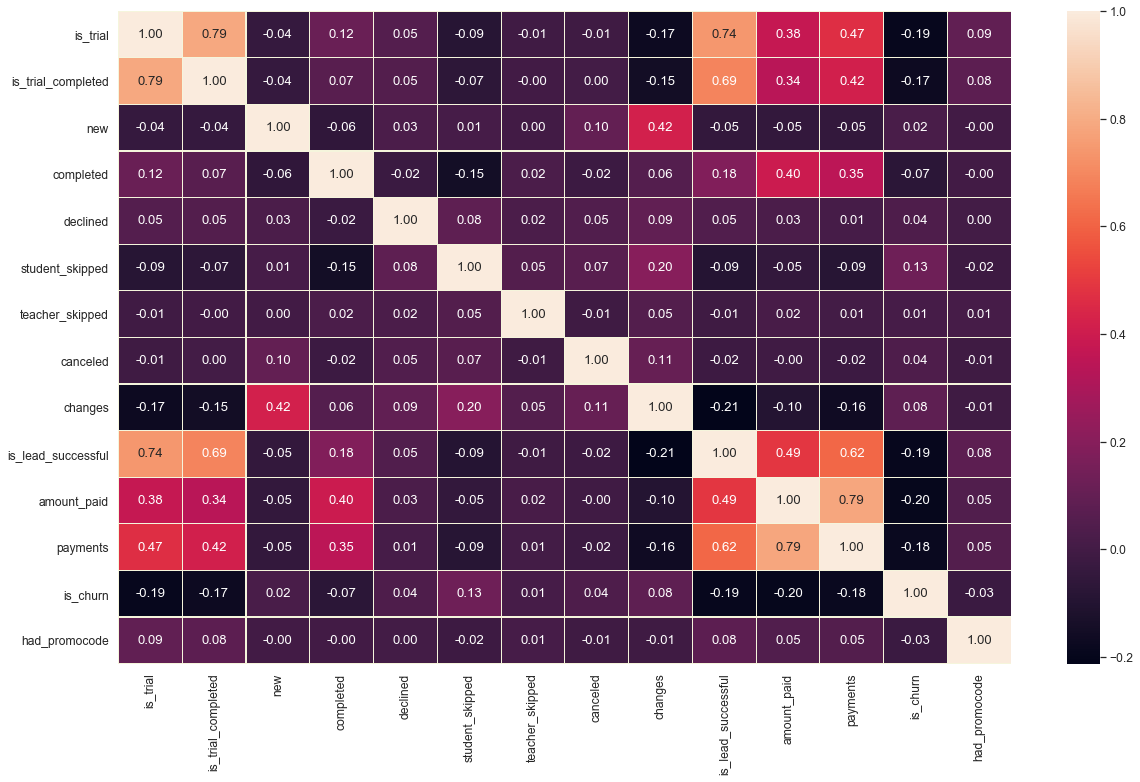

In [49]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=1.1)
sns.heatmap(df.drop(columns=['id','age']).corr(),annot=True,fmt='.2f',linewidths=0.1,linecolor='beige',);

In [50]:
df['is_churn'].value_counts()

1    3878
0    2263
Name: is_churn, dtype: int64

## 4. Построение модели <a name="4step"></a> 

In [51]:
y = df['is_churn'] #целевая переменная
X = df.drop(columns=['id','first_activity','last_activity','is_churn','utm_source',\
                     'utm_medium','promocode','utm_source_edit']) #признаки

Итак, какие признаки будут использоваться для модели:

1. Метрики количества пройденных уроков по типам уроков: completed, declined, canceled, new, student_skipped, teacher_skipped
2. Уровень языка: language_level
3. Пол студента: gender
4.
5. Выручка от студента за недели 0-3: amount_paid
6. Количество платежей, поступивших от студента за недели 0-3: payments
7. Был ли использован промокод для оплаты: had_promocode
8. Количество замен учителей для студента в недели 0-3: changes
9. Был ли студент приглашен на пробное занятие, когда он был лидом: is_trial
10. Прошел ли студент пробное занятие: is_trial_completed
11. Был ли лид успешным: is_lead_successful


Какие признаки не будем использовать:

1. Идентификатор студента: id
2. Даты первой и последней активности: first_activity и last_activity
3. Utm метки: utm_source (и обработанный столбец utm_source_edit) и utm_medium из-за того, что более чем по половине студентов отсутствует информация
4. Название промокода: promocode, т.к. был создан дополнительный столбец со значениями 0 (без промокода)/ 1 (с промокодом)

Для решения задачи сравним несколько моделей:

1. Модель логистической регрессии
2. Модель случайного леса
3. Дерево принятия решений
4. Наивный байесовский классификатор

Разделим выборку на обучающую и валидационную:

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### 4.1. Без resampling-а целевой переменной <a name="4.1step"></a> 

### а. Логистическая регрессия

In [53]:
#обучаем модель логистической регрессии
model = LogisticRegression(random_state = 42)
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
#воспользуемся обученной моделью на валидационной выборке
log_predictions = model.predict(X_test)
log_probabilities = model.predict_proba(X_test)[:,1]

In [55]:
print(confusion_matrix(y_test, log_predictions))
print(classification_report(y_test, log_predictions))

[[143 318]
 [116 652]]
              precision    recall  f1-score   support

           0       0.55      0.31      0.40       461
           1       0.67      0.85      0.75       768

    accuracy                           0.65      1229
   macro avg       0.61      0.58      0.57      1229
weighted avg       0.63      0.65      0.62      1229



In [56]:
log_score = model.score(X_test, y_test)
log_score

0.6468673718470301

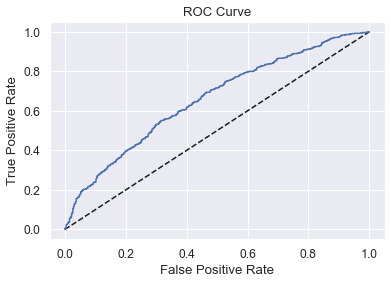

In [57]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, log_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [58]:
log_features = pd.DataFrame({'feature': X_train.columns,
              'importance': np.round(model.coef_[0], 6)}).sort_values('importance', ascending=False).head(10)
log_features

,feature,importance
8,student_skipped,0.485067
7,declined,0.155350
10,canceled,0.102735
0,age,0.092037
6,completed,0.063317
14,payments,0.062459
11,changes,0.061269
5,new,0.046874
9,teacher_skipped,0.012023
13,amount_paid,-0.000183


### b. Модель случайного леса

In [59]:
#обучаем модель случайного леса
rf_model = RandomForestClassifier(random_state=42, n_estimators=30, 
                             criterion='gini', min_samples_split=2, min_samples_leaf=1, max_depth=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [60]:
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [61]:
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

[[144 317]
 [113 655]]
              precision    recall  f1-score   support

           0       0.56      0.31      0.40       461
           1       0.67      0.85      0.75       768

    accuracy                           0.65      1229
   macro avg       0.62      0.58      0.58      1229
weighted avg       0.63      0.65      0.62      1229



In [62]:
rf_score = rf_model.score(X_test, y_test)
rf_score

0.6501220504475184

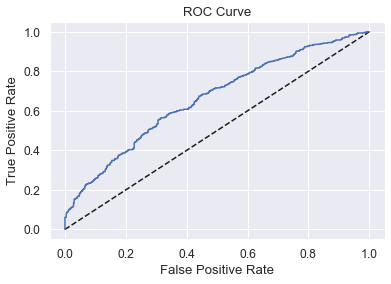

In [63]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [64]:
rf_features = pd.DataFrame({'feature': X_train.columns,
              'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False).head(10)
rf_features

,feature,importance
13,amount_paid,0.153471
6,completed,0.138749
2,language_level,0.116870
0,age,0.114928
8,student_skipped,0.075340
1,gender,0.072579
11,changes,0.067830
3,is_trial,0.060603
12,is_lead_successful,0.035271
7,declined,0.034838


### c. Модель дерева принятия решений

In [65]:
tree_model = DecisionTreeClassifier(random_state=42, criterion='gini', 
                                    min_samples_split=2, min_samples_leaf=1, max_depth=10)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [66]:
tree_predictions = tree_model.predict(X_test)
tree_probabilities = tree_model.predict_proba(X_test)[:,1]

In [67]:
print(confusion_matrix(y_test, tree_predictions))
print(classification_report(y_test, tree_predictions))

[[208 253]
 [194 574]]
              precision    recall  f1-score   support

           0       0.52      0.45      0.48       461
           1       0.69      0.75      0.72       768

    accuracy                           0.64      1229
   macro avg       0.61      0.60      0.60      1229
weighted avg       0.63      0.64      0.63      1229



In [68]:
tree_score = tree_model.score(X_test, y_test)
tree_score

0.6362896663954435

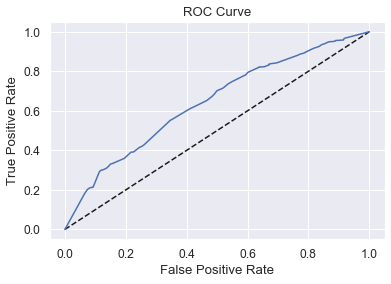

In [69]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, tree_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [70]:
tree_features = pd.DataFrame({'feature': X_train.columns,
              'importance': tree_model.feature_importances_}).sort_values('importance', ascending=False).head(10)
tree_features

,feature,importance
0,age,0.156137
6,completed,0.146716
3,is_trial,0.134898
13,amount_paid,0.131956
2,language_level,0.125653
8,student_skipped,0.079338
11,changes,0.074099
10,canceled,0.030778
7,declined,0.023938
1,gender,0.022220


### d. Модель наивной байесовской классификации

In [71]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [72]:
gnb_predictions = gnb.predict(X_test)
gnb_probabilities = gnb.predict_proba(X_test)[:,1]

In [73]:
print(confusion_matrix(y_test, gnb_predictions))
print(classification_report(y_test, gnb_predictions))

[[289 172]
 [340 428]]
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       461
           1       0.71      0.56      0.63       768

    accuracy                           0.58      1229
   macro avg       0.59      0.59      0.58      1229
weighted avg       0.62      0.58      0.59      1229



In [74]:
gnb_score = gnb.score(X_test, y_test)
gnb_score

0.5834011391375101

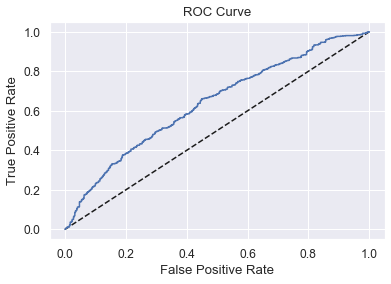

In [75]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, gnb_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Сравнение моделей по метрике accuracy

In [76]:
data = [['Log_model',log_score],
        ['Random forest',rf_score],
        ['Decision tree',tree_score],
        ['Naive Bayes',gnb_score]
       ]
columns= ['Model','Accuracy']

metrics = pd.DataFrame(data = data, columns = columns)
metrics

,Model,Accuracy
0,Log_model,0.646867
1,Random forest,0.650122
2,Decision tree,0.636290
3,Naive Bayes,0.583401


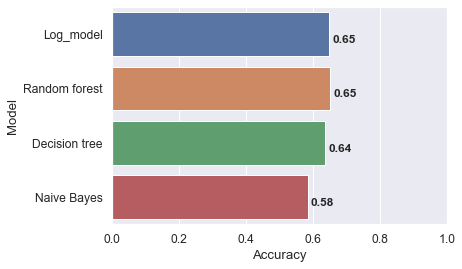

In [77]:
ax = sns.barplot(x='Accuracy', y='Model', data=metrics);
plt.xlim(0,1)

initialx=0
for p in ax.patches:
    ax.text(p.get_width()+0.01,initialx+p.get_height()/5,'{:.2f}'.format(p.get_width()),weight='bold', size=12)
    initialx+=1

### 4.2. С downsampling-ом целевой переменной <a name="4.2step"></a> 

Перед обучением модели проведем downsampling целевой переменной, чтобы избежать влияния дисбаланса на результат модели.

In [78]:
training_set = pd.concat([X_train, y_train], axis=1)

churn = training_set[training_set['is_churn'] == 1]
not_churn = training_set[training_set['is_churn'] == 0]

In [79]:
# Undersampling the majority
churn_downsampled = resample(churn, 
                       replace=False, 
                       n_samples=len(not_churn),
                       random_state=42)

# Returning to new training set
downsampled_train = pd.concat([not_churn, churn_downsampled])
downsampled_train['is_churn'].value_counts()

1    1802
0    1802
Name: is_churn, dtype: int64

In [80]:
# Separate undersampled data into X and y sets
downsampled_X_train = downsampled_train.drop('is_churn', axis=1)
downsampled_y_train = downsampled_train['is_churn']

### a. Логистическая регрессия

In [81]:
#обучаем модель логистической регрессии
down_log_model = LogisticRegression(random_state = 42)
down_log_model.fit(downsampled_X_train,downsampled_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
#воспользуемся обученной моделью на валидационной выборке
log_predictions = down_log_model.predict(X_test)
log_probabilities = down_log_model.predict_proba(X_test)[:,1]

In [83]:
print(confusion_matrix(y_test, log_predictions))
print(classification_report(y_test, log_predictions))

[[314 147]
 [331 437]]
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       461
           1       0.75      0.57      0.65       768

    accuracy                           0.61      1229
   macro avg       0.62      0.63      0.61      1229
weighted avg       0.65      0.61      0.62      1229



In [84]:
log_score = down_log_model.score(X_test, y_test)
log_score

0.6110659072416599

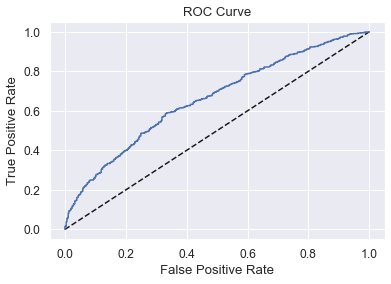

In [85]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, log_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [86]:
pd.DataFrame({'feature': downsampled_X_train.columns,
              'importance': np.round(down_log_model.coef_[0], 6)}).sort_values('importance', ascending=False).head(10)

,feature,importance
8,student_skipped,0.339827
0,age,0.103839
7,declined,0.095603
10,canceled,0.038650
11,changes,0.036847
6,completed,0.034583
5,new,0.029767
14,payments,0.013487
9,teacher_skipped,0.008667
13,amount_paid,-0.000156


### b. Модель случайного леса

In [87]:
#обучаем модель случайного леса
down_rf_model = RandomForestClassifier(random_state=42, n_estimators=30, 
                             criterion='gini', min_samples_split=2, min_samples_leaf=1, max_depth=10)
down_rf_model.fit(downsampled_X_train, downsampled_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [88]:
rf_predictions = down_rf_model.predict(X_test)
rf_probabilities = down_rf_model.predict_proba(X_test)[:,1]

In [89]:
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

[[294 167]
 [324 444]]
              precision    recall  f1-score   support

           0       0.48      0.64      0.54       461
           1       0.73      0.58      0.64       768

    accuracy                           0.60      1229
   macro avg       0.60      0.61      0.59      1229
weighted avg       0.63      0.60      0.61      1229



In [90]:
rf_score = down_rf_model.score(X_test, y_test)
rf_score

0.6004882017900732

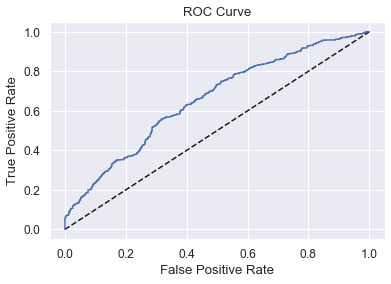

In [91]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [92]:
pd.DataFrame({'feature': downsampled_X_train.columns,
              'importance': down_rf_model.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
13,amount_paid,0.140066
6,completed,0.133793
2,language_level,0.133594
0,age,0.120183
1,gender,0.074445
8,student_skipped,0.073108
3,is_trial,0.069663
11,changes,0.066526
12,is_lead_successful,0.042461
7,declined,0.034372


### c. Модель дерева принятия решений

In [93]:
down_tree_model = DecisionTreeClassifier(random_state=42, criterion='gini', 
                                    min_samples_split=2, min_samples_leaf=1, max_depth=10)
down_tree_model.fit(downsampled_X_train, downsampled_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [94]:
tree_predictions = down_tree_model.predict(X_test)
tree_probabilities = down_tree_model.predict_proba(X_test)[:,1]

In [95]:
print(confusion_matrix(y_test, tree_predictions))
print(classification_report(y_test, tree_predictions))

[[261 200]
 [300 468]]
              precision    recall  f1-score   support

           0       0.47      0.57      0.51       461
           1       0.70      0.61      0.65       768

    accuracy                           0.59      1229
   macro avg       0.58      0.59      0.58      1229
weighted avg       0.61      0.59      0.60      1229



In [96]:
tree_score = down_tree_model.score(X_test, y_test)
tree_score

0.5931651749389748

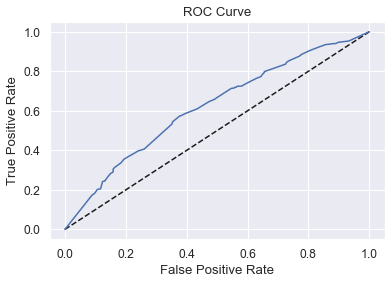

In [97]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, tree_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [98]:
pd.DataFrame({'feature': downsampled_X_train.columns,
              'importance': down_tree_model.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
6,completed,0.161326
2,language_level,0.140226
3,is_trial,0.134389
0,age,0.134114
13,amount_paid,0.126985
8,student_skipped,0.076136
11,changes,0.066464
1,gender,0.043436
7,declined,0.035923
10,canceled,0.022749


### d. Модель наивной байесовской классификации

In [99]:
down_gnb = GaussianNB()
down_gnb.fit(downsampled_X_train, downsampled_y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [100]:
gnb_predictions = down_gnb.predict(X_test)
gnb_probabilities = down_gnb.predict_proba(X_test)[:,1]

In [101]:
print(confusion_matrix(y_test, gnb_predictions))
print(classification_report(y_test, gnb_predictions))

[[309 152]
 [374 394]]
              precision    recall  f1-score   support

           0       0.45      0.67      0.54       461
           1       0.72      0.51      0.60       768

    accuracy                           0.57      1229
   macro avg       0.59      0.59      0.57      1229
weighted avg       0.62      0.57      0.58      1229



In [102]:
gnb_score = down_gnb.score(X_test, y_test)
gnb_score

0.5720097640358015

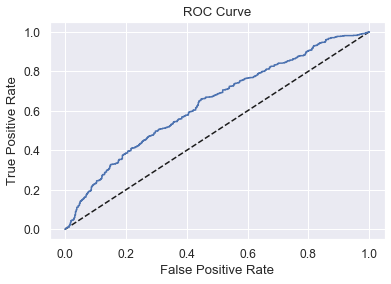

In [103]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, gnb_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Сравнение моделей по метрике accuracy

In [104]:
data = [['Log_model',log_score],
        ['Random forest',rf_score],
        ['Decision tree',tree_score],
        ['Naive Bayes',gnb_score]
       ]
columns= ['Model','Accuracy']

metrics = pd.DataFrame(data = data, columns = columns)
metrics

,Model,Accuracy
0,Log_model,0.611066
1,Random forest,0.600488
2,Decision tree,0.593165
3,Naive Bayes,0.572010


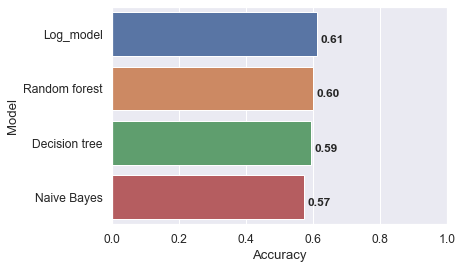

In [105]:
ax = sns.barplot(x='Accuracy', y='Model', data=metrics);
plt.xlim(0,1)

initialx=0
for p in ax.patches:
    ax.text(p.get_width()+0.01,initialx+p.get_height()/5,'{:.2f}'.format(p.get_width()),weight='bold', size=12)
    initialx+=1

### 4.3. С oversampling-ом целевой переменной <a name="4.3step"></a> 

Перед обучением модели проведем downsampling целевой переменной, чтобы избежать влияния дисбаланса на результат модели.

In [106]:
# Oversampling the minority
not_churn_oversample = resample(not_churn, 
                       replace=True, 
                       n_samples=len(churn),
                       random_state=42)
# Returning to new training set

oversample_train = pd.concat([churn, not_churn_oversample])
oversample_train['is_churn'].value_counts()

1    3110
0    3110
Name: is_churn, dtype: int64

In [107]:
# Separate undersampled data into X and y sets
oversample_X_train = oversample_train.drop('is_churn', axis=1)
oversample_y_train = oversample_train['is_churn']

### a. Логистическая регрессия

In [108]:
#обучаем модель логистической регрессии
up_log_model = LogisticRegression(random_state = 42)
up_log_model.fit(oversample_X_train,oversample_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
#воспользуемся обученной моделью на валидационной выборке
log_predictions = up_log_model.predict(X_test)
log_probabilities = up_log_model.predict_proba(X_test)[:,1]

In [110]:
print(confusion_matrix(y_test, log_predictions))
print(classification_report(y_test, log_predictions))

[[308 153]
 [344 424]]
              precision    recall  f1-score   support

           0       0.47      0.67      0.55       461
           1       0.73      0.55      0.63       768

    accuracy                           0.60      1229
   macro avg       0.60      0.61      0.59      1229
weighted avg       0.64      0.60      0.60      1229



In [111]:
log_score = up_log_model.score(X_test, y_test)
log_score

0.595606183889341

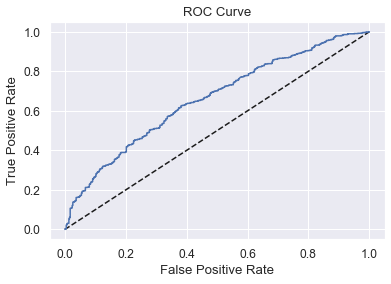

In [112]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, log_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [113]:
pd.DataFrame({'feature': oversample_X_train.columns,
              'importance': np.round(up_log_model.coef_[0], 6)}).sort_values('importance', ascending=False).head(10)

,feature,importance
8,student_skipped,0.493248
7,declined,0.153167
0,age,0.065888
10,canceled,0.056485
5,new,0.042810
6,completed,0.038372
14,payments,0.034969
9,teacher_skipped,0.018634
11,changes,0.009453
13,amount_paid,-0.000178


### b. Модель случайного леса

In [114]:
#обучаем модель случайного леса
up_rf_model = RandomForestClassifier(random_state=42, n_estimators=30, 
                             criterion='gini', min_samples_split=2, min_samples_leaf=1, max_depth=10)
up_rf_model.fit(oversample_X_train, oversample_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [115]:
rf_predictions = up_rf_model.predict(X_test)
rf_probabilities = up_rf_model.predict_proba(X_test)[:,1]

In [116]:
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

[[260 201]
 [269 499]]
              precision    recall  f1-score   support

           0       0.49      0.56      0.53       461
           1       0.71      0.65      0.68       768

    accuracy                           0.62      1229
   macro avg       0.60      0.61      0.60      1229
weighted avg       0.63      0.62      0.62      1229



In [117]:
rf_score = up_rf_model.score(X_test, y_test)
rf_score

0.6175752644426363

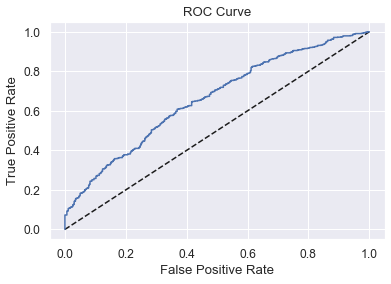

In [118]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [119]:
pd.DataFrame({'feature': oversample_X_train.columns,
              'importance': up_rf_model.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
13,amount_paid,0.152198
6,completed,0.140634
2,language_level,0.128131
0,age,0.108672
8,student_skipped,0.085073
1,gender,0.071816
3,is_trial,0.065417
11,changes,0.059474
12,is_lead_successful,0.039406
14,payments,0.036783


### c. Модель дерева принятия решений

In [120]:
up_tree_model = DecisionTreeClassifier(random_state=42, criterion='gini', 
                                    min_samples_split=2, min_samples_leaf=1, max_depth=10)
up_tree_model.fit(oversample_X_train, oversample_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [121]:
tree_predictions = up_tree_model.predict(X_test)
tree_probabilities = up_tree_model.predict_proba(X_test)[:,1]

In [122]:
print(confusion_matrix(y_test, tree_predictions))
print(classification_report(y_test, tree_predictions))

[[286 175]
 [344 424]]
              precision    recall  f1-score   support

           0       0.45      0.62      0.52       461
           1       0.71      0.55      0.62       768

    accuracy                           0.58      1229
   macro avg       0.58      0.59      0.57      1229
weighted avg       0.61      0.58      0.58      1229



In [123]:
tree_score = up_tree_model.score(X_test, y_test)
tree_score

0.5777054515866559

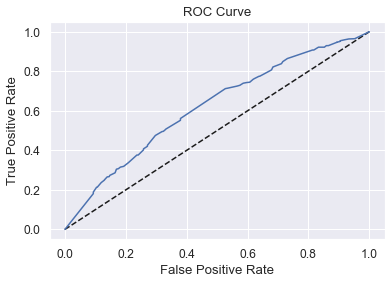

In [124]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, tree_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [125]:
pd.DataFrame({'feature': oversample_X_train.columns,
              'importance': up_tree_model.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
3,is_trial,0.148082
2,language_level,0.143315
0,age,0.129877
6,completed,0.116002
13,amount_paid,0.109849
8,student_skipped,0.095410
11,changes,0.078102
7,declined,0.034451
1,gender,0.030358
10,canceled,0.028515


### d. Модель наивной байесовской классификации

In [126]:
up_gnb = GaussianNB()
up_gnb.fit(oversample_X_train, oversample_y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [127]:
gnb_predictions = up_gnb.predict(X_test)
gnb_probabilities = up_gnb.predict_proba(X_test)[:,1]

In [128]:
print(confusion_matrix(y_test, gnb_predictions))
print(classification_report(y_test, gnb_predictions))

[[307 154]
 [371 397]]
              precision    recall  f1-score   support

           0       0.45      0.67      0.54       461
           1       0.72      0.52      0.60       768

    accuracy                           0.57      1229
   macro avg       0.59      0.59      0.57      1229
weighted avg       0.62      0.57      0.58      1229



In [129]:
gnb_score = up_gnb.score(X_test, y_test)
gnb_score

0.5728234336859235

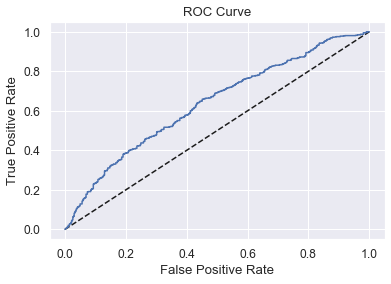

In [130]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, gnb_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Сравнение моделей по метрике accuracy

In [131]:
data = [['Log_model',log_score],
        ['Random forest',rf_score],
        ['Decision tree',tree_score],
        ['Naive Bayes',gnb_score]
       ]
columns= ['Model','Accuracy']

metrics = pd.DataFrame(data = data, columns = columns)
metrics

,Model,Accuracy
0,Log_model,0.595606
1,Random forest,0.617575
2,Decision tree,0.577705
3,Naive Bayes,0.572823


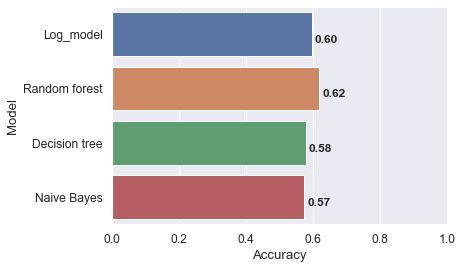

In [132]:
ax = sns.barplot(x='Accuracy', y='Model', data=metrics);
plt.xlim(0,1)

initialx=0
for p in ax.patches:
    ax.text(p.get_width()+0.01,initialx+p.get_height()/5,'{:.2f}'.format(p.get_width()),weight='bold', size=12)
    initialx+=1

### 4.4. По самым важным признакам <a name="4.4step"></a> 

Для каждой модели возьмем те признаки, которые имеют важность более, чем 0.05

### а. Логистическая регрессия

In [133]:
log_features_list = log_features.query('importance >= 0.05')['feature']
log_features_list

8     student_skipped
7            declined
10           canceled
0                 age
6           completed
14           payments
11            changes
Name: feature, dtype: object

In [134]:
y = df['is_churn'] #целевая переменная
X = df[log_features_list] #признаки

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [136]:
#обучаем модель логистической регрессии
cut_log_model = LogisticRegression(random_state = 42)
cut_log_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
#воспользуемся обученной моделью на валидационной выборке
log_predictions = cut_log_model.predict(X_test)
log_probabilities = cut_log_model.predict_proba(X_test)[:,1]

In [138]:
print(confusion_matrix(y_test, log_predictions))
print(classification_report(y_test, log_predictions))

[[ 67 394]
 [ 48 720]]
              precision    recall  f1-score   support

           0       0.58      0.15      0.23       461
           1       0.65      0.94      0.77       768

    accuracy                           0.64      1229
   macro avg       0.61      0.54      0.50      1229
weighted avg       0.62      0.64      0.57      1229



In [139]:
log_score = cut_log_model.score(X_test, y_test)
log_score

0.6403580146460537

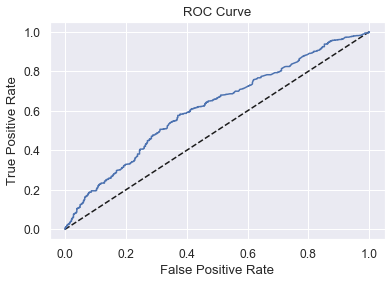

In [140]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, log_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [141]:
pd.DataFrame({'feature': X_train.columns,
              'importance': np.round(cut_log_model.coef_[0], 6)}).sort_values('importance', ascending=False).head(10)

,feature,importance
0,student_skipped,0.361740
1,declined,0.136419
2,canceled,0.091233
6,changes,0.065590
4,completed,-0.003466
3,age,-0.015952
5,payments,-0.585479


### b. Модель случайного леса

In [142]:
rf_features_list = rf_features.query('importance >= 0.05')['feature']
rf_features_list

13        amount_paid
6           completed
2      language_level
0                 age
8     student_skipped
1              gender
11            changes
3            is_trial
Name: feature, dtype: object

In [143]:
y = df['is_churn'] #целевая переменная
X = df[rf_features_list] #признаки

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [145]:
#обучаем модель случайного леса
cut_rf_model = RandomForestClassifier(random_state=42, n_estimators=30, 
                             criterion='gini', min_samples_split=2, min_samples_leaf=1, max_depth=10)
cut_rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [146]:
rf_predictions = cut_rf_model.predict(X_test)
rf_probabilities = cut_rf_model.predict_proba(X_test)[:,1]

In [147]:
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

[[140 321]
 [114 654]]
              precision    recall  f1-score   support

           0       0.55      0.30      0.39       461
           1       0.67      0.85      0.75       768

    accuracy                           0.65      1229
   macro avg       0.61      0.58      0.57      1229
weighted avg       0.63      0.65      0.62      1229



In [148]:
rf_score = cut_rf_model.score(X_test, y_test)
rf_score

0.646053702196908

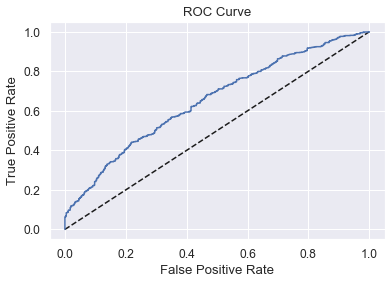

In [149]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, rf_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [150]:
rf_features = pd.DataFrame({'feature': X_train.columns,
              'importance': cut_rf_model.feature_importances_}).sort_values('importance', ascending=False).head(10)
rf_features

,feature,importance
0,amount_paid,0.191458
1,completed,0.167408
3,age,0.152532
2,language_level,0.140399
6,changes,0.088610
7,is_trial,0.088259
4,student_skipped,0.086180
5,gender,0.085154


### c. Модель дерева принятия решений

In [151]:
tree_features_list = tree_features.query('importance >= 0.05')['feature']
tree_features_list

0                 age
6           completed
3            is_trial
13        amount_paid
2      language_level
8     student_skipped
11            changes
Name: feature, dtype: object

In [152]:
y = df['is_churn'] #целевая переменная
X = df[tree_features_list] #признаки

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [154]:
cut_tree_model = DecisionTreeClassifier(random_state=42, criterion='gini', 
                                    min_samples_split=2, min_samples_leaf=1, max_depth=10)
cut_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [155]:
tree_predictions = cut_tree_model.predict(X_test)
tree_probabilities = cut_tree_model.predict_proba(X_test)[:,1]

In [156]:
print(confusion_matrix(y_test, tree_predictions))
print(classification_report(y_test, tree_predictions))

[[152 309]
 [164 604]]
              precision    recall  f1-score   support

           0       0.48      0.33      0.39       461
           1       0.66      0.79      0.72       768

    accuracy                           0.62      1229
   macro avg       0.57      0.56      0.55      1229
weighted avg       0.59      0.62      0.60      1229



In [157]:
tree_score = cut_tree_model.score(X_test, y_test)
tree_score

0.6151342554922702

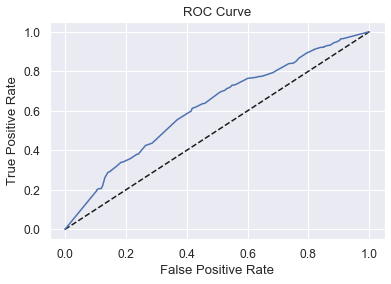

In [158]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_test, tree_probabilities)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [159]:
tree_features = pd.DataFrame({'feature': X_train.columns,
              'importance': cut_tree_model.feature_importances_}).sort_values('importance', ascending=False).head(10)
tree_features

,feature,importance
0,age,0.202706
1,completed,0.172771
3,amount_paid,0.165567
2,is_trial,0.140604
4,language_level,0.138504
6,changes,0.090913
5,student_skipped,0.088935


### Сравнение моделей по метрике accuracy

In [160]:
data = [['Log_model',log_score],
        ['Random forest',rf_score],
        ['Decision tree',tree_score],
        ['Naive Bayes',gnb_score]
       ]
columns= ['Model','Accuracy']

metrics = pd.DataFrame(data = data, columns = columns)
metrics

,Model,Accuracy
0,Log_model,0.640358
1,Random forest,0.646054
2,Decision tree,0.615134
3,Naive Bayes,0.572823


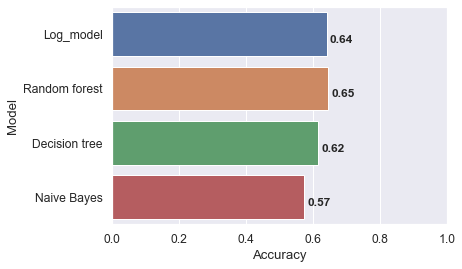

In [161]:
ax = sns.barplot(x='Accuracy', y='Model', data=metrics);
plt.xlim(0,1)

initialx=0
for p in ax.patches:
    ax.text(p.get_width()+0.01,initialx+p.get_height()/5,'{:.2f}'.format(p.get_width()),weight='bold', size=12)
    initialx+=1